We will reproduce the results for P-crh prediction using pytorch


In [1]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib
import datetime as dt

### Load ERA5 + IMERG data

In [286]:
fil='/neelin2020/ML_input/era5_condensed_thermo1_2016_01_01.npz'
f=np.load(fil,'r')
print(f.keys())
that_ocn=f['That_ocn']
cwv_ocn=f['cwv_ocn']
crh=f['crh_ocn']
# cwv_sat_ocn=f['cwv_sat_ocean']
# prc_ocn=f['prc_trmm_ocean']
f.close()

fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_2016_01_01.npz'
f=np.load(fil,'r')
prc_ocn=f['prc_ocn']


KeysView(<numpy.lib.npyio.NpzFile object at 0x7efc164413a0>)


### Load ERA-I+TRMM 3B42 data

In [287]:
# ### Read data ###
# # fil='/neelin2020/ML_input/cwv_precip_ocns.200201.npz'
# fil='/neelin2020/ML_input/era5_condensed_thermo1_2016_01_01.npz'
# f=np.load(fil,'r')
# print(f.keys())
# that_ocn=f['that_ocean']
# cwv_ocn=f['cwv_ocean']
# cwv_sat_ocn=f['cwv_sat_ocean']
# prc_ocn=f['prc_trmm_ocean']
# f.close()

In [288]:
# crh=cwv_ocn/cwv_sat_ocn

In [289]:
pcp_bins=2**(np.arange(0,8.,0.25))

In [290]:
crh.size,prc_ocn.size,pcp_bins.max()

(3620040, 3620040, 215.2694823049509)

In [291]:
### Bin precip. by crh ###
crh_bins=np.arange(0,1.05,.05)
crh_index=np.int_((crh-crh_bins[0])/np.diff(crh_bins)[0])
pcp_crh_joint_pdf=np.zeros((crh_bins.size,pcp_bins.size-1))
pcp_crh_binned=np.zeros((crh_bins.size))
for i,j in enumerate(crh_bins):
    indx=np.where(crh_index==i)[0]
    pcp_crh_joint_pdf[i,:]=np.histogram(prc_ocn[indx],bins=pcp_bins)[0]
    pcp_crh_binned[i]=prc_ocn[indx].mean()

/tmp/ipykernel_151006/3182337906.py:9: RuntimeWarning: Mean of empty slice.
  pcp_crh_binned[i]=prc_ocn[indx].mean()


In [292]:
cmap=plt.get_cmap('RdYlGn_r')
dr=np.diff(crh_bins)[0]
dpr=np.diff(pcp_bins)
pcp_crh_joint_norm=pcp_crh_joint_pdf/(pcp_crh_joint_pdf.sum()*dpr*dr)

In [293]:
pcp_marginal=pcp_crh_joint_pdf.sum(0)
pcp_marginal_pdf=pcp_marginal/(pcp_marginal.sum()*dpr)

/tmp/ipykernel_151006/399443565.py:5: RuntimeWarning: divide by zero encountered in log
  np.log(pcp_crh_joint_norm).T,cmap=plt.get_cmap('YlOrRd'))


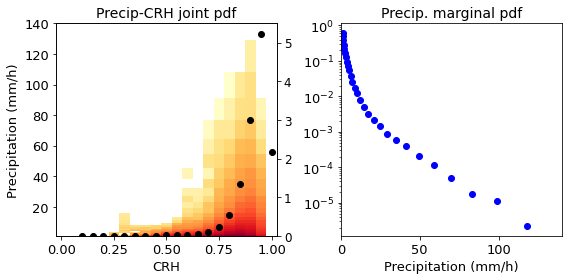

In [296]:
fig,axx=plt.subplots(1,2,figsize=(8,4))

ax=axx[0]
ax.pcolormesh(crh_bins,0.5*(pcp_bins[1:]+pcp_bins[:-1]),
              np.log(pcp_crh_joint_norm).T,cmap=plt.get_cmap('YlOrRd'))
ax.tick_params(which='both',labelsize=13)
ax.set_xlabel('CRH',fontsize=13)
ax.set_ylabel('Precipitation (mm/h)',fontsize=13)
ax.set_ylim(top=14e1)
ax2=ax.twinx()
ax2.scatter(crh_bins,pcp_crh_binned,color='black')
ax2.set_ylim(bottom=0)
ax2.tick_params(which='both',labelsize=12)
ax.set_title('Precip-CRH joint pdf',fontsize=14)

ax=axx[1]
ax.scatter(0.5*(pcp_bins[1:]+pcp_bins[:-1]),
              pcp_marginal_pdf,color='blue')

ax.tick_params(which='both',labelsize=13)
ax.set_xlabel('Precipitation (mm/h)',fontsize=13)
# ax.set_ylim(top=14e1)
ax.set_title('Precip. marginal pdf',fontsize=14)
ax.set_yscale('log')
ax.set_xlim(1e-10,right=140)
plt.tight_layout()

SAVE=True
if SAVE:
    plt.savefig('/home/fiaz/ML/plots/Imerg_ERA5_precip_joint_pdf.pdf',
               format='pdf',bbox_inches='tight',dpi=125)

#### Train NN on the crh data:
    - Single input and single output

In [297]:
## randomize data
ind_random=np.arange(crh.size)
np.random.shuffle(ind_random)
crh_random=crh[ind_random]
prc_random=prc_ocn[ind_random]

In [57]:
#### Partition data into training, validation and test datasets ####
## 10% of the data kept aside for testing
## another 10% for validation during training

## Normalize precip. data and 
## use a sigmoid last layer activation to prevent 
## negative precip. values

# prc_random=prc_random/prc_max

ix=(int(0.1*crh.size)) 

crh_test=crh_random[:ix]
prc_test=prc_random[:ix]

crh_validate=crh_random[ix:2*ix]
prc_validate=prc_random[ix:2*ix]

crh_train=crh_random[2*ix:]
prc_train=prc_random[2*ix:]

prc_max=prc_train.max()
prc_mean=prc_train.mean()
prc_std=prc_train.std()

norm=lambda x,xbar,denom:(x-xbar)/denom
normalizer=prc_max*2#prc_std*3

prc_test,prc_validate,prc_train=map(norm,[prc_test,prc_validate,prc_train],
                                    itertools.repeat(0,3),
                                   itertools.repeat(normalizer,3))


In [58]:
prc_mean,prc_std

(0.15789028032878683, 1.3211293033283618)

## Train simple feedforward network using Pytorch

In [195]:
ix_sub=500000
ix

362004

Convert input and targets into Tensor Data

In [196]:
train_data=torch.utils.data.TensorDataset(torch.from_numpy(crh_train[:ix_sub]).float().unsqueeze(1),
                                          torch.from_numpy(prc_train[:ix_sub]).float().unsqueeze(1))

val_data=torch.utils.data.TensorDataset(torch.from_numpy(crh_validate[:ix_sub]).float().unsqueeze(1),
                                          torch.from_numpy(prc_validate[:ix_sub]).float().unsqueeze(1))

Create data loader

In [197]:
#create training datasets
training_loader=torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False, 
                                            num_workers=0)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=False, num_workers=0)
print('Training set has {} instances'.format(len(train_data.tensors[0])))
print('Validation set has {} instances'.format(len(val_data.tensors[0])))

Training set has 500000 instances
Validation set has 362004 instances


### Build neural network architecture using pytorch subclassing


In [198]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__() ## initialize the super class
        
        self.flatten=nn.Flatten()
        self.layer1=nn.Linear(1,12)
        self.layer2=nn.Linear(12,12)
        self.layer3=nn.Linear(12,1)
        
    def forward(self,x):
        x=self.flatten(x)
        x=torch.relu(self.layer1(x))
#         x=torch.relu(self.layer2(x))
        x=torch.sigmoid(self.layer3(x))
#         x=torch.relu(self.layer3(x))
        
        return x
        
model_crh=NeuralNetwork().to(device)

In [199]:
model_crh

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=1, out_features=12, bias=True)
  (layer2): Linear(in_features=12, out_features=12, bias=True)
  (layer3): Linear(in_features=12, out_features=1, bias=True)
)

Set loss function and optimizer

In [200]:
### Set loss function
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.RMSprop(model_crh.parameters())

# val_loss_fn=torch.nn.functional.
### Set optimizer
# optimizer=torch.optim.SGD(model.parameters(),
#                           lr=0.001,
#                           momentum=0.0)
# #                          weight_decay=0.1) ## stochastic gradient descent, learning rate and momentum


#                              lr=0.1)
# optimizer=torch.optim.Adam(model.parameters())

#                          weight_decay=0.1) ## stochastic gradient descent, learning rate and momentum


## Among SGD, RMSprop and Adam, RMSprop works the best. SGD is worst.

### Train over epochs

In [201]:
def train_one_epoch(epoch_index, tb_writer):
    
    for i, data in enumerate(training_loader):

        running_loss = 0.
        last_loss = 0.

        inputs,truth=data
        
        ### Zero gradients for each batch to prevent accumulations
        optimizer.zero_grad()

        outputs=model_crh(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, truth)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        running_loss += loss.item()

        if i % 500 == 499:
#         if i == len(training_loader)-1:

            last_loss = running_loss / len(training_loader) # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            

#     print('{:2e}'.format(last_loss))
    return last_loss
        

In [202]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/home/fiaz/ML/logs/pytorch_{}'.format(timestamp))

EPOCH 1:
  batch 500 loss: 8.598301470796354e-09
  batch 1000 loss: 5.659509515643602e-09
  batch 1500 loss: 3.676640942793205e-09
LOSS train 0.0 valid 0.00695359380915761
EPOCH 2:
  batch 500 loss: 8.518442809090833e-09
  batch 1000 loss: 5.79840806780546e-09
  batch 1500 loss: 3.715582582879761e-09
LOSS train 0.0 valid 0.0069258795119822025
EPOCH 3:
  batch 500 loss: 8.465118678582178e-09
  batch 1000 loss: 5.83360514040186e-09
  batch 1500 loss: 3.7189990061709652e-09
LOSS train 0.0 valid 0.006905617658048868
EPOCH 4:
  batch 500 loss: 8.577754523961623e-09
  batch 1000 loss: 5.851884401368098e-09
  batch 1500 loss: 3.7239500272266248e-09
LOSS train 0.0 valid 0.006933123338967562
EPOCH 5:
  batch 500 loss: 8.557748433239205e-09
  batch 1000 loss: 5.863089245767166e-09
  batch 1500 loss: 3.734463208817692e-09
LOSS train 0.0 valid 0.006905561778694391
EPOCH 6:
  batch 500 loss: 8.54666786472825e-09
  batch 1000 loss: 5.881874919341145e-09
  batch 1500 loss: 3.7462950180905e-09
LOSS tr

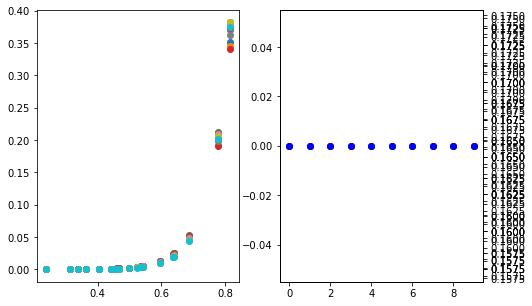

In [204]:
fig,axx=plt.subplots(1,2,figsize=(8,5))
### training loop
epoch_number = 0
EPOCHS = 10
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_crh.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model_crh.train(False)

#     # evaluate model: turn off dropouts and batch normalization
#     model.eval()

    
    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        vinputs, vtruth = vdata
        voutputs = model_crh(vinputs)
        vloss = loss_fn(voutputs, vtruth)
        running_vloss += vloss
#         print(i,vloss)
        
    avg_vloss = running_vloss*normalizer / (i + 1)

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss*normalizer*24, 'Validation' : avg_vloss*24 },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    axx[0].scatter(vinputs.detach(),(voutputs.detach())*normalizer)
    axx[1].scatter(epoch_number,avg_loss,color='black')
    ax2=axx[1].twinx()
    ax2.scatter(epoch_number,avg_vloss.detach()*24,color='blue')
    
#     plt.show()
        
    epoch_number += 1

In [205]:
loss_fn(voutputs,vtruth)

tensor(1.0277e-07, grad_fn=<MseLossBackward>)

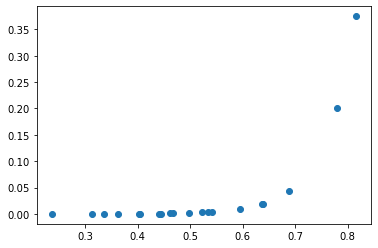

In [206]:
plt.scatter(vinputs.detach(),(voutputs.detach())*normalizer)

### Plot binned precip

In [208]:
x=np.copy(crh_bins)
x=x[None,:]
pcp_binned_pred_crh=model_crh(torch.from_numpy(crh_bins).float().unsqueeze(1))*normalizer
pcp_binned_pred_crh=pcp_binned_pred_crh.detach().numpy().squeeze()


### Predict precip ###

In [266]:
date=dt.datetime(2016,1,2)
fil='/neelin2020/ML_input/era5_condensed_thermo1_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil,'r')
crh_test=f['crh_ocn']
f.close()

fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil,'r')
prc_test=f['prc_ocn']

In [210]:
pcp_pred_crh=model_crh(torch.from_numpy(crh_test).float().unsqueeze(1))*normalizer
pcp_pred_crh=pcp_pred_crh.detach()

In [274]:
pcp_bins=2**(np.arange(0,8.,0.25))

In [275]:
def bin_prc_crh(prc,crh,crh_bins):

    crh_indx=np.int_((crh-crh_bins[0])/np.diff(crh_bins)[0])
    
    prc_crh_binned=np.zeros((crh_bins.size))
    prc_crh_joint=np.zeros((crh_bins.size,pcp_bins.size-1))

    for i in np.arange(crh_bins.size):
        indx=np.where(crh_indx==i)[0]
        prc_crh_binned[i]=prc[indx].mean()
        prc_crh_joint[i,:]=np.histogram(prc[indx],bins=pcp_bins)[0]
        
    return [prc_crh_binned,prc_crh_joint]

In [276]:
pcp_binned_pred_crh,prc_crh_joint=bin_prc_crh(pcp_pred_crh,crh_test,crh_bins)

In [277]:
pcp_binned_pred_obs,prc_crh_joint_obs=bin_prc_crh(prc_test,crh_test,crh_bins)

/tmp/ipykernel_151006/377606399.py:10: RuntimeWarning: Mean of empty slice.
  prc_crh_binned[i]=prc[indx].mean()
/home/fiaz/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/tmp/ipykernel_151006/2200706154.py:19: RuntimeWarning: divide by zero encountered in log10
  np.log10(pdf).T,cmap=plt.get_cmap('YlOrRd'))
/tmp/ipykernel_151006/2200706154.py:29: RuntimeWarning: divide by zero encountered in log10
  np.log10(pdf).T,cmap=plt.get_cmap('YlOrRd'))


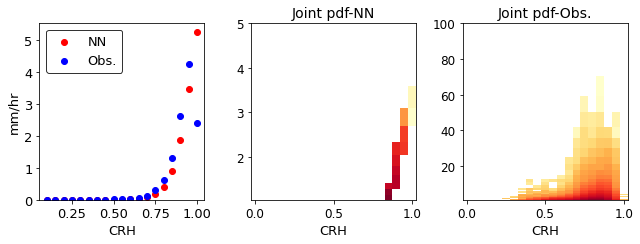

In [278]:
dirp='/Users/fiaz_ahmed/Dropbox/Paper/ML/'

fig,axx=plt.subplots(1,3,figsize=(9,3.5))

ax=axx[0]
ln1=ax.scatter(crh_bins,pcp_binned_pred,label='predicted',color='red')
ln2=ax.scatter(crh_bins,pcp_binned_pred_obs,label='conditional_mean',color='blue')
ax.set_ylabel('mm/hr',fontsize=13)
ax.set_xlabel('CRH',fontsize=13)
leg=ax.legend((ln1,ln2),('NN','Obs.'),fontsize=13)
frame=leg.get_frame()
frame.set_edgecolor('black')
ax.set_ylim(bottom=0)
ax.tick_params(which='both',labelsize=13)

ax=axx[1]
pdf=prc_crh_joint/(prc_crh_joint.sum()*np.diff(pcp_bins)*np.diff(crh_bins)[0])
ax.pcolormesh(crh_bins,(pcp_bins[1:]+pcp_bins[:1])*0.5,
             np.log10(pdf).T,cmap=plt.get_cmap('YlOrRd'))
ax.set_ylim(top=5)
ax.tick_params(which='both',labelsize=12)
ax.set_xlabel('CRH',fontsize=13)
ax.set_title('Joint pdf-NN',fontsize=14)


ax=axx[2]
pdf=prc_crh_joint_obs/(prc_crh_joint_obs.sum()*np.diff(pcp_bins)*np.diff(crh_bins)[0])
ax.pcolormesh(crh_bins,(pcp_bins[1:]+pcp_bins[:1])*0.5,
             np.log10(pdf).T,cmap=plt.get_cmap('YlOrRd'))
ax.set_ylim(top=1e2)
ax.tick_params(which='both',labelsize=12)
ax.set_xlabel('CRH',fontsize=13)
ax.set_title('Joint pdf-Obs.',fontsize=14)
plt.tight_layout()

SAVE=False
dirp='/home/fiaz/ML/plots/'
if SAVE:
    plt.savefig(dirp+'precip_NN_stats_crh.pdf',dpi=125,bbox_inches='tight')

In [280]:
prc_crh_marginal=prc_crh_joint.sum(0)/(prc_crh_joint.sum()*np.diff(pcp_bins))


In [284]:
pcp_bins.size,prc_crh_marginal.size

(32, 31)

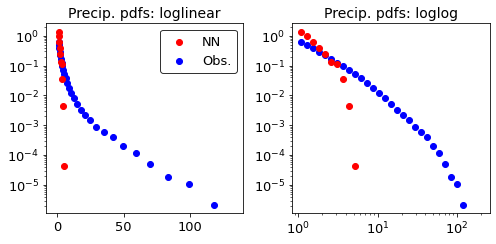

In [299]:
fig,axx=plt.subplots(1,2,figsize=(7,3.5))

ax=axx[0]
ln2=ax.scatter((pcp_bins[1:]+pcp_bins[:-1])*0.5,pcp_marginal_pdf,
          label='Obs.',color='blue')

ln1=ax.scatter((pcp_bins[1:]+pcp_bins[:-1])*0.5,
               prc_crh_marginal,label='NN',color='red')
ax.set_yscale('log')
ax.tick_params(which='both',labelsize=13)
leg=ax.legend((ln1,ln2),('NN','Obs.'),fontsize=13)
frame=leg.get_frame()
frame.set_edgecolor('black')
ax.set_title('Precip. pdfs: loglinear',fontsize=14)
ax.set_xlim(right=1.4e2)

ax=axx[1]

ax.scatter((pcp_bins[1:]+pcp_bins[:-1])*0.5,pcp_marginal_pdf,
          label='predicted',color='blue')
ln1=ax.scatter((pcp_bins[1:]+pcp_bins[:-1])*0.5,
               prc_crh_marginal,label='predicted',color='red')
ax.set_title('Precip. pdfs: loglog',fontsize=14)


ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(which='both',labelsize=13)
plt.tight_layout()

dirp='/home/fiaz/ML/plots/'
SAVE=True
if SAVE:
    plt.savefig(dirp+'precip_NNS_pdfs_crh.pdf',dpi=125,bbox_inches='tight')

Despite the drop in rainfall at high crh values due to sampling, the NN learns the high expected rainfall values

### The simple feedforward neural network performs well, but training data suggests overfitting

## Rainfall pdfs

In [73]:
## predict precipitation time series
prc_predicted=model(torch.from_numpy(crh_test).float().unsqueeze(1))*normalizer
prc_predicted=prc_predicted.detach().numpy().squeeze()

In [74]:
prc_predicted

array([3.1497987e-04, 1.4482550e-03, 1.8573193e-02, ..., 8.1726359e-03,
       1.1904442e-04, 2.1326184e-01], dtype=float32)

/tmp/ipykernel_151006/803290395.py:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left=0,right=1e2)


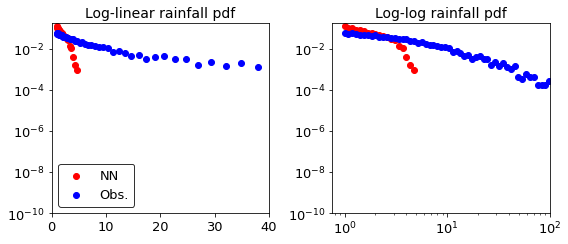

In [75]:
pcp_bins=2**(np.arange(0,8.125,0.125))

pcp_pred_hist=np.histogram(prc_predicted,bins=pcp_bins)
pcp_test_hist=np.histogram(prc_test*normalizer,bins=pcp_bins)


fig,axx=plt.subplots(1,2,figsize=(8,3.5))

ax=axx[0]
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red',label='NN')
ax.scatter(pcp_bins[:-1],pcp_test_hist[0]/(pcp_test_hist[0].sum()),c='blue',label='Obs.')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(left=0,right=40)
ax.set_ylim(bottom=1e-10)
ax.tick_params(which='both',labelsize=13)
ax.legend(fontsize=13).get_frame().set_edgecolor('black')
ax.set_title('Log-linear rainfall pdf',fontsize=14)

ax=axx[1]
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red')
ax.scatter(pcp_bins[:-1],pcp_test_hist[0]/(pcp_test_hist[0].sum()),c='blue')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(left=0,right=1e2)
ax.set_ylim(bottom=1e-10)
ax.tick_params(which='both',labelsize=13)
ax.set_title('Log-log rainfall pdf',fontsize=14)

plt.tight_layout()
SAVE=False
if SAVE:
    plt.savefig('/home/fiaz/ML/plots/rainfall_pdfs_crh_input.pdf',
               format='pdf',bbox_inches='tight',dpi=125)

The pdf tails are not captured by the neural network. The variability in crh is inadequate. Next, we look at CWV and $\hat{T}$ variables are predictors for precipitation

### Read data

In [50]:
# import glob
# fils=glob.glob('/neelin2020/ML_input/era5_condensed_thermo1_2016*npz')

# # fil='/neelin2020/ML_input/era5_condensed_thermo1_2016_01_01.npz'


# # f=np.load(fil,'r')
# # print(f.keys())
# # that_ocn=f['That_ocn']
# # cwv_ocn=f['cwv_ocn']
# # crh=f['crh_ocn']
# # f.close()

# # fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_2016_01_01.npz'
# # f=np.load(fil,'r')
# # prc_ocn=f['prc_ocn']


## Prep. data

### Randomize data

In [58]:
## randomize data
ind_random=np.arange(cwv_ocn.size)
np.random.shuffle(ind_random)

### Partition into training, test and validation

In [137]:
def randomize_split(data,data_dict,indx_random,
                    p=10,idx_sub=None):
    
    '''
    Takes a single dimensional array data and randomized
    indices indx_random. Splits data into training, test and validation
    datasets. Test and validation data are p percent of the data
    '''
    
    data_randomized=data[indx_random]
    
    idx=int(p*1e-2*data.size)
    idx_train=int(data.size*(100-2*p)*1e-2)
    
    if idx_sub:
        data_train=data_randomized[:idx_sub]
    else:
        data_train=data_randomized[:idx_train]
    
    data_validate=data_randomized[idx_train:idx_train+idx]
    data_test=data_randomized[idx_train+idx:]
    
    data_dict['train'],data_dict['validate'],data_dict['test']=data_train,data_validate,data_test
    

In [60]:
prc={}
randomize_split(prc_ocn,prc,ind_random)
cwv={}
randomize_split(cwv_ocn,cwv,ind_random)
That={}
randomize_split(that_ocn,That,ind_random)


### Normalize data. 
  Use 2*prc_max for precip and std dev. for cwv and $\hat{T}$

In [141]:
def normalize_data(data_dict,data_norm_dict,
                   xbar,normalizer):
    for key in data_dict.keys():
        data_norm_dict[key]=(data_dict[key]-xbar)/normalizer
    data_norm_dict['xbar']=xbar
    data_norm_dict['normalizer']=normalizer


In [62]:
prc_norm={}
normalize_data(prc,prc_norm,0,
               2*prc['train'].max())

cwv_norm={}
normalize_data(cwv,cwv_norm,cwv['train'].mean(),
               cwv['train'].std())

That_norm={}
normalize_data(That,That_norm,That['train'].mean(),
               That['train'].std())

### Create data loader 

In [63]:
### dimension zero of the input tensors must match
x=np.vstack((cwv_norm['train'],That_norm['train'])).T
train_data=torch.utils.data.TensorDataset(torch.from_numpy(x).float().unsqueeze(2),
                                          torch.from_numpy(prc_norm['train']).float().unsqueeze(1))

x=np.vstack((cwv_norm['validate'],That_norm['validate'])).T
val_data=torch.utils.data.TensorDataset(torch.from_numpy(x).float().unsqueeze(2),
                                          torch.from_numpy(prc_norm['validate']).float().unsqueeze(1))

In [65]:
x.shape

(362004, 2)

In [67]:
#create training datasets
training_loader=torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False, 
                                            num_workers=0)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=False, num_workers=0)
print('Training set has {} instances'.format(len(train_data.tensors[0])))
print('Validation set has {} instances'.format(len(val_data.tensors[0])))

Training set has 2896032 instances
Validation set has 362004 instances


### Build NN architecture 

In [68]:
class NeuralNetwork_2D(nn.Module):
    def __init__(self):
        super(NeuralNetwork_2D,self).__init__() ## initialize the super class
        
        self.flatten=nn.Flatten()
        self.layer1=nn.Linear(2,24)
        self.layer2=nn.Linear(24,24)
        self.layer3=nn.Linear(24,1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        x=self.flatten(x)
        x=torch.relu(self.layer1(x))
        x=self.dropout(x)
        x=torch.relu(self.layer2(x))
        x=self.dropout(x)
        x=torch.sigmoid(self.layer3(x))
#         x=torch.relu(self.layer3(x))
        
        return x
        
model=NeuralNetwork_2D().to(device)

In [69]:
print(model)

NeuralNetwork_2D(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=2, out_features=24, bias=True)
  (layer2): Linear(in_features=24, out_features=24, bias=True)
  (layer3): Linear(in_features=24, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Set loss function 

In [70]:
### Set loss function
loss_fn=torch.nn.MSELoss()
# loss_fn=torch.nn.L1Loss() ### L1 loss function performs worse than MSE loss
optimizer=torch.optim.RMSprop(model.parameters(),lr=0.0001)

### Train

In [74]:
def train_one_epoch_2D(epoch_index, tb_writer):
    
    for i, data in enumerate(training_loader):

        running_loss = 0.
        last_loss = 0.

        inputs,truth=data
        print(inputs.shape,truth.shape)
        break
        
        ### Zero gradients for each batch to prevent accumulations
        optimizer.zero_grad()
        outputs=model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, truth)
        
        ## Add L1 regularization
        l1_lambda = 1e-3
        l1_norm = sum(p.pow(2).sum() for p in model.parameters())
#         print(loss)
        loss = loss + l1_lambda * l1_norm
#         print(loss)
        
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        running_loss += loss.item()

        if i % 500 == 499:
#         if i == len(training_loader)-1:

            last_loss = running_loss / len(training_loader) # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            

#     print('{:2e}'.format(last_loss))
    return last_loss
        

In [75]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/home/fiaz/ML/logs/pytorch_{}'.format(timestamp))

EPOCH 1:
torch.Size([256, 2, 1]) torch.Size([256, 1])


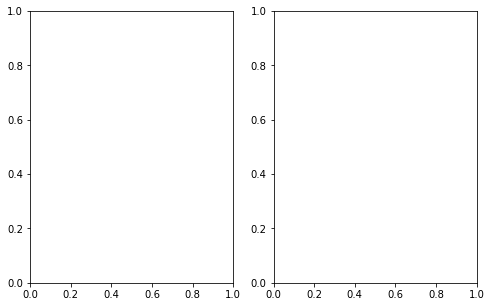

In [76]:
fig,axx=plt.subplots(1,2,figsize=(8,5))
### training loop
epoch_number = 0
EPOCHS = 10
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch_2D(epoch_number, writer)
    break
    # We don't need gradients on to do reporting
    model.train(False)

#     # evaluate model: turn off dropouts and batch normalization
#     model.eval()

    
    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        vinputs, vtruth = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vtruth)
        running_vloss += vloss
        
    avg_vloss = running_vloss*prc_norm['normalizer'] / (i + 1)

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss*prc_norm['normalizer']*24, 
                     'Validation' : avg_vloss*prc_norm['normalizer']*24 },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    axx[0].scatter(vinputs.detach()[:,0],(voutputs.detach())*prc_norm['normalizer'])
    axx[1].scatter(epoch_number,avg_loss,color='black')
    ax2=axx[1].twinx()
    ax2.scatter(epoch_number,avg_vloss.detach()*24,color='blue')
    
#     plt.show()
        
    epoch_number += 1
    

### Test prediction

In [ ]:
cwv_bins=np.arange(0,82.5,2.5)
That_bins=np.arange(260,270,1.)

In [575]:
def bin_2D(varz,varx,vary,binx,biny):
    varx_indx=np.int_((varx-binx[0])/np.diff(binx)[0])
    vary_indx=np.int_((vary-biny[0])/np.diff(biny)[0])

    binned_2D_var=np.zeros((binx.size,biny.size))
    
    for i in range(binx.size):
        for j in range(biny.size):
            ind=np.where(np.logical_and(varx_indx==i,vary_indx==j))
            binned_2D_var[i,j]=varz[ind].mean()
            
    return binned_2D_var
        
    
prc_cwv_That_binned=bin_2D(prc_ocn_test,cwv_ocn_test,that_ocn_test,
                          cwv_bins,That_bins)

/tmp/ipykernel_357018/2003230111.py:10: RuntimeWarning: Mean of empty slice.
  binned_2D_var[i,j]=varz[ind].mean()
/home/fiaz/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [576]:
cmap=plt.get_cmap('jet')
cmap_norm=matplotlib.colors.Normalize(vmin=0,vmax=That_bins.size)

(0.0, 5.0)

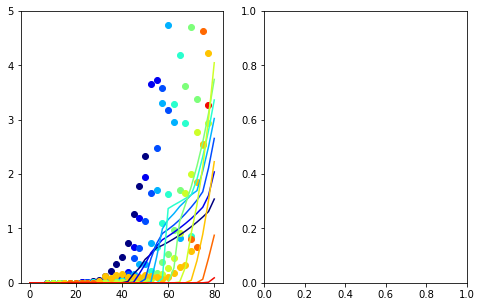

In [577]:
fig,axx=plt.subplots(1,2,figsize=(8,5))
ax=axx[0]
for i in range(That_bins.size):
    ax.scatter(cwv_bins,prc_cwv_That_binned[:,i],color=cmap(cmap_norm(i)))
    
    ### prep input
    x=np.vstack(((cwv_bins-cwv_norm['xbar'])/cwv_norm['normalizer'],
             np.repeat((That_bins[i]-That_norm['xbar'])/That_norm['normalizer'],
                       cwv_bins.size)))
    
    predicted_precip=model(torch.from_numpy(x.T).float().unsqueeze(2))*prc_norm['normalizer']
    ax.plot(cwv_bins,predicted_precip.detach(),
           color=cmap(cmap_norm(i)))

ax.set_ylim(bottom=0,top=5)

Use a second day's data to predict precipitation

In [578]:
import glob
# fils=glob.glob('/neelin2020/ML_input/era5_condensed_thermo1_2016*npz')

fil_test='/neelin2020/ML_input/era5_condensed_thermo1_2016_01_02.npz'
f=np.load(fil_test,'r')
print(f.keys())
that_ocn_test=f['That_ocn']
cwv_ocn_test=f['cwv_ocn']
f.close()

fil_test='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_2016_01_02.npz'
f=np.load(fil_test,'r')
prc_ocn_test=f['prc_ocn']

KeysView(<numpy.lib.npyio.NpzFile object at 0x7feee1cf7850>)


One shallow layer is not enough. Perhaps try a deeper layer?

In [579]:
x1=(cwv_ocn_test-cwv_norm['xbar'])/cwv_norm['normalizer']
x2=(that_ocn_test-That_norm['xbar'])/That_norm['normalizer']

x=np.vstack((x1,x2))
prc_predicted=model(torch.from_numpy(x.T).float().unsqueeze(1))*prc_norm['normalizer']
prc_predicted=prc_predicted.detach().numpy().squeeze()

/tmp/ipykernel_357018/3990900582.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left=0,right=1e2)


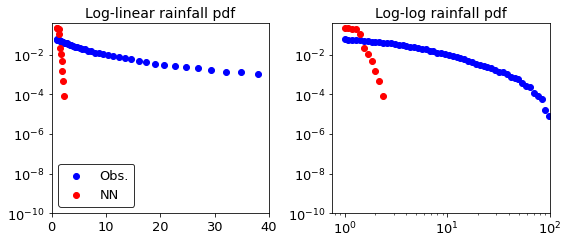

In [580]:
pcp_bins=2**(np.arange(0,8.125,0.125))

pcp_pred_hist=np.histogram(prc_predicted,bins=pcp_bins)
pcp_test_hist=np.histogram(prc_ocn_test,bins=pcp_bins)


fig,axx=plt.subplots(1,2,figsize=(8,3.5))

ax=axx[0]
ax.scatter(pcp_bins[:-1],pcp_test_hist[0]/(pcp_test_hist[0].sum()),c='blue',label='Obs.')
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red',label='NN')

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(left=0,right=40)
ax.set_ylim(bottom=1e-10)
ax.tick_params(which='both',labelsize=13)
ax.legend(fontsize=13).get_frame().set_edgecolor('black')
ax.set_title('Log-linear rainfall pdf',fontsize=14)

ax=axx[1]
ax.scatter(pcp_bins[:-1],pcp_test_hist[0]/(pcp_test_hist[0].sum()),c='blue')
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(left=0,right=1e2)
ax.set_ylim(bottom=1e-10)
ax.tick_params(which='both',labelsize=13)
ax.set_title('Log-log rainfall pdf',fontsize=14)

plt.tight_layout()
SAVE=False
if SAVE:
    plt.savefig('/home/fiaz/ML/plots/rainfall_pdfs_crh_input.pdf',
               format='pdf',bbox_inches='tight',dpi=125)

### Use three theta_e-based variables that reconstruct buoyancy

### Load variables

In [134]:
date=dt.datetime(2016,1,1)
fil='/neelin2020/ML_input/era5_condensed_thermo2_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil,'r')
thetae_bl_ocn=f['thetae_bl_ocn']
thetae_lt_ocn=f['thetae_lt_ocn']
thetae_sat_lt_ocn=f['thetae_sat_lt_ocn']
f.close()

fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil,'r')
prc_ocn=f['prc_ocn']

### remove zero values from input array

ind_nonzero=np.where(thetae_bl_ocn>0)

remove_zeros=lambda x,ind:x[ind]
list1=list(map(remove_zeros,[thetae_bl_ocn,thetae_lt_ocn,
                  thetae_sat_lt_ocn,prc_ocn],itertools.repeat(ind_nonzero)))

thetae_bl_ocn,thetae_lt_ocn,thetae_sat_lt_ocn,prc_ocn=list1

### Prep. data

In [138]:
## randomize data
ind_random=np.arange(thetae_bl_ocn.size)
np.random.shuffle(ind_random)

In [139]:
### randomize split data
thetae_bl={}
randomize_split(thetae_bl_ocn,thetae_bl,ind_random)
thetae_lt={}
randomize_split(thetae_lt_ocn,thetae_lt,ind_random)
thetae_sat_lt={}
randomize_split(thetae_sat_lt_ocn,thetae_sat_lt,ind_random)
prc={}
randomize_split(prc_ocn,prc,ind_random)


### Normalize data

In [142]:
prc_norm={}
normalize_data(prc,prc_norm,0,
               2*prc['train'].max())

thetae_bl_norm={}
normalize_data(thetae_bl,thetae_bl_norm,thetae_bl['train'].mean(),
               thetae_bl['train'].std())

thetae_lt_norm={}
normalize_data(thetae_lt,thetae_lt_norm,thetae_lt['train'].mean(),
               thetae_lt['train'].std())

thetae_sat_lt_norm={}
normalize_data(thetae_sat_lt,thetae_sat_lt_norm,thetae_sat_lt['train'].mean(),
               thetae_sat_lt['train'].std())

### Create data loader 

In [143]:
### dimension zero of the input tensors must match
x=np.vstack((thetae_bl_norm['train'],thetae_lt_norm['train'],thetae_sat_lt_norm['train'])).T

train_data=torch.utils.data.TensorDataset(torch.from_numpy(x).float().unsqueeze(2),
                                          torch.from_numpy(prc_norm['train']).float().unsqueeze(1))

x=np.vstack((thetae_bl_norm['validate'],thetae_lt_norm['validate'],thetae_sat_lt_norm['validate'])).T
val_data=torch.utils.data.TensorDataset(torch.from_numpy(x).float().unsqueeze(2),
                                          torch.from_numpy(prc_norm['validate']).float().unsqueeze(1))

In [144]:
#create training datasets
training_loader=torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False, 
                                            num_workers=0)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=False, num_workers=0)
print('Training set has {} instances'.format(len(train_data.tensors[0])))
print('Validation set has {} instances'.format(len(val_data.tensors[0])))

Training set has 2895908 instances
Validation set has 361988 instances


### NN Architecture

In [145]:
class NeuralNetwork_3D(nn.Module):
    def __init__(self):
        super(NeuralNetwork_3D,self).__init__() ## initialize the super class
        
        self.flatten=nn.Flatten()
        self.layer1=nn.Linear(3,24)
        self.layer2=nn.Linear(24,24)
        self.layer3=nn.Linear(24,1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        x=self.flatten(x)
        x=torch.relu(self.layer1(x))
#         x=self.dropout(x)
        x=torch.relu(self.layer2(x))
#         x=self.dropout(x)
        x=torch.sigmoid(self.layer3(x))
#         x=torch.relu(self.layer3(x))
        
        return x
        
model=NeuralNetwork_3D().to(device)

In [146]:
### Set loss function and optimizer
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.RMSprop(model.parameters())

### Train

In [147]:
def train_one_epoch_3D(epoch_index, tb_writer):
    
    for i, data in enumerate(training_loader):

        running_loss = 0.
        last_loss = 0.

        inputs,truth=data
        
        ### Zero gradients for each batch to prevent accumulations
        optimizer.zero_grad()
        outputs=model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, truth)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        running_loss += loss.item()

        if i % 500 == 499:
#         if i == len(training_loader)-1:

            last_loss = running_loss / len(training_loader) # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            

#     print('{:2e}'.format(last_loss))
    return last_loss
        

In [148]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/home/fiaz/ML/logs/pytorch_{}'.format(timestamp))

In [150]:
### training loop
epoch_number = 0
EPOCHS = 10
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch_3D(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)

#     # evaluate model: turn off dropouts and batch normalization
#     model.eval()

    
    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        vinputs, vtruth = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vtruth)
        running_vloss += vloss
        
    avg_vloss = running_vloss*prc_norm['normalizer'] / (i + 1)

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss*prc_norm['normalizer']*24, 
                     'Validation' : avg_vloss*prc_norm['normalizer']*24 },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

#     axx[0].scatter(vinputs.detach()[:,0],(voutputs.detach())*prc_norm['normalizer'])
#     axx[1].scatter(epoch_number,avg_loss,color='black')
#     ax2=axx[1].twinx()
#     ax2.scatter(epoch_number,avg_vloss.detach()*24,color='blue')    
#     plt.show()
        
    epoch_number += 1
    

EPOCH 1:
  batch 500 loss: 2.835389165920498e-09
  batch 1000 loss: 1.952287899096872e-09
  batch 1500 loss: 1.2027871961538519e-07
  batch 2000 loss: 9.077187069567163e-09
  batch 2500 loss: 2.583307269700912e-09
  batch 3000 loss: 1.6147081346265908e-10
  batch 3500 loss: 1.028912087699006e-09
  batch 4000 loss: 1.0633499642945121e-09
  batch 4500 loss: 1.560488386495566e-09
  batch 5000 loss: 6.664882168853533e-10
  batch 5500 loss: 1.220898998898449e-09
  batch 6000 loss: 4.5617070647701915e-08
  batch 6500 loss: 9.399694871619818e-10
  batch 7000 loss: 2.1978943988478816e-09
  batch 7500 loss: 1.8440714553452143e-09
  batch 8000 loss: 1.800706252739068e-09
  batch 8500 loss: 8.023505501040291e-10
  batch 9000 loss: 1.8635071312156128e-09
  batch 9500 loss: 6.077299792490809e-10
  batch 10000 loss: 1.7668265500774794e-09
  batch 10500 loss: 7.4298370752292944e-09
  batch 11000 loss: 2.0758840727099874e-10
LOSS train 0.0 valid 0.006739387288689613
EPOCH 2:
  batch 500 loss: 2.661361

  batch 6500 loss: 7.484185513685067e-10
  batch 7000 loss: 1.9280975749764734e-09
  batch 7500 loss: 1.5895886796264905e-09
  batch 8000 loss: 1.79470421477876e-09
  batch 8500 loss: 4.2161482790827324e-10
  batch 9000 loss: 1.88289199822439e-09
  batch 9500 loss: 6.239172243171114e-10
  batch 10000 loss: 1.769147357383303e-09
  batch 10500 loss: 7.558658763393859e-09
  batch 11000 loss: 3.6969476362042773e-10
LOSS train 0.0 valid 0.006658950354903936
EPOCH 10:
  batch 500 loss: 2.7867962781311565e-09
  batch 1000 loss: 1.813211021049204e-09
  batch 1500 loss: 1.954399682604887e-09
  batch 2000 loss: 8.849466253832031e-09
  batch 2500 loss: 2.6010903712683276e-09
  batch 3000 loss: 1.648525170345721e-10
  batch 3500 loss: 9.826448308415912e-10
  batch 4000 loss: 1.0363985965925976e-09
  batch 4500 loss: 1.4513969369687737e-09
  batch 5000 loss: 5.570597164845946e-10
  batch 5500 loss: 1.1347018455518733e-09
  batch 6000 loss: 4.5970113771651224e-08
  batch 6500 loss: 7.650857874306974

### Test network

In [250]:
date=dt.datetime(2016,1,2)
fil='/neelin2020/ML_input/era5_condensed_thermo2_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil,'r')
thetae_bl_test=f['thetae_bl_ocn']
thetae_lt_test=f['thetae_lt_ocn']
thetae_sat_lt_test=f['thetae_sat_lt_ocn']
f.close()

fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil,'r')
prc_test=f['prc_ocn']

### remove zero values from input array

ind_nonzero=np.where(thetae_bl_test>0)

remove_zeros=lambda x,ind:x[ind]
list1=list(map(remove_zeros,[thetae_bl_test,thetae_lt_test,
                  thetae_sat_lt_test,prc_test],itertools.repeat(ind_nonzero)))

thetae_bl_test,thetae_lt_test,thetae_sat_lt_test,prc_test=list1

In [251]:
wb=0.5
cape=(thetae_bl_test-thetae_sat_lt_test)/thetae_sat_lt_test
subsat=(thetae_sat_lt_test-thetae_lt_test)/thetae_sat_lt_test
BL=cape*wb-(1-wb)*subsat
BL*=340

In [252]:
BL_bins=np.arange(-40,5.,1.)
pcp_bins=2**(np.arange(0,8.,0.25))

def bin_prc_bl(prc,BL,BL_bins):

    BL_indx=np.int_((BL-BL_bins[0])/np.diff(BL_bins)[0])
    
    prc_bl_binned=np.zeros((BL_bins.size))
    bl_pdf_binned=np.zeros((BL_bins.size))
    prc_bl_joint=np.zeros((BL_bins.size,pcp_bins.size-1))

    for i in np.arange(BL_bins.size):
        indx=np.where(BL_indx==i)[0]
        prc_bl_binned[i]=prc[indx].mean()
        bl_pdf_binned[i]=indx.size
        prc_bl_joint[i,:]=np.histogram(prc[indx],bins=pcp_bins)[0]
        
    return [prc_bl_binned,bl_pdf_binned,prc_bl_joint]

In [253]:
prc_bl_binned,bl_pdf_binned,prc_bl_joint=bin_prc_bl(prc_test,BL,BL_bins)

/tmp/ipykernel_151006/2974421551.py:14: RuntimeWarning: Mean of empty slice.
  prc_bl_binned[i]=prc[indx].mean()


### Obs. baseline

/tmp/ipykernel_151006/2842765551.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'))


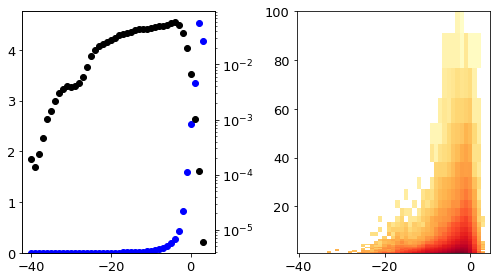

In [254]:
fig,axx=plt.subplots(1,2,figsize=(7,4))

ax=axx[0]
ax.scatter(BL_bins,prc_bl_binned,color='blue')
ax.set_ylim(bottom=0)
ax.tick_params(which='both',labelsize=13)

ax2=ax.twinx()
pdf=bl_pdf_binned/(bl_pdf_binned.sum()*np.diff(BL_bins)[0])
ax2.scatter(BL_bins,pdf,color='black')
ax2.tick_params(which='both',labelsize=13)
ax2.set_yscale('log')

ax=axx[1]
pdf_norm=prc_bl_joint/(prc_bl_joint.sum()*np.diff(pcp_bins)*np.diff(BL_bins)[0])
ax.pcolormesh(BL_bins,(pcp_bins[1:]+pcp_bins[:-1])*0.5,
           np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'))
ax.set_ylim(top=100)
ax.tick_params(which='both',labelsize=13)

plt.tight_layout()


### NN prediction

In [255]:
x1=(thetae_bl_test-thetae_bl_norm['xbar'])/thetae_bl_norm['normalizer']
x2=(thetae_lt_test-thetae_lt_norm['xbar'])/thetae_lt_norm['normalizer']
x3=(thetae_sat_lt_test-thetae_sat_lt_norm['xbar'])/thetae_sat_lt_norm['normalizer']

x=np.vstack((x1,x2,x3))
prc_predicted=model(torch.from_numpy(x.T).float().unsqueeze(1))*prc_norm['normalizer']
prc_predicted=prc_predicted.detach().numpy().squeeze()

In [256]:
prc_bl_binned_NN,bl_pdf_binned_NN,prc_bl_joint_NN=bin_prc_bl(prc_predicted,BL,BL_bins)

/tmp/ipykernel_151006/2974421551.py:14: RuntimeWarning: Mean of empty slice.
  prc_bl_binned[i]=prc[indx].mean()


/tmp/ipykernel_151006/3046754546.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'))
/tmp/ipykernel_151006/3046754546.py:26: RuntimeWarning: divide by zero encountered in log10
  np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'))


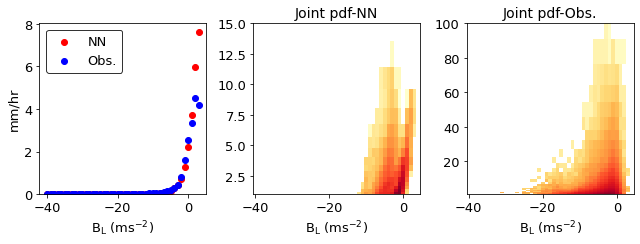

In [257]:
fig,axx=plt.subplots(1,3,figsize=(9,3.5))

ax=axx[0]
ax.scatter(BL_bins,prc_bl_binned_NN,color='red',label='NN')
ax.scatter(BL_bins,prc_bl_binned,color='blue',label='Obs.')

ax.set_ylim(bottom=0)
ax.tick_params(which='both',labelsize=13)
ax.legend(fontsize=13).get_frame().set_edgecolor('black')
ax.set_xlabel("$\mathrm{B_L}\ \mathrm{(ms^{-2})}$",fontsize=13)
ax.set_ylabel('mm/hr',fontsize=13)


ax=axx[1]
pdf_norm=prc_bl_joint_NN/(prc_bl_joint_NN.sum()*np.diff(pcp_bins)*np.diff(BL_bins)[0])
ax.pcolormesh(BL_bins,(pcp_bins[1:]+pcp_bins[:-1])*0.5,
           np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'))
ax.set_ylim(top=15)
ax.tick_params(which='both',labelsize=13)
ax.set_title('Joint pdf-NN',fontsize=14)
ax.set_xlabel("$\mathrm{B_L}\ \mathrm{(ms^{-2})}$",fontsize=13)

ax=axx[2]
pdf_norm=prc_bl_joint/(prc_bl_joint.sum()*np.diff(pcp_bins)*np.diff(BL_bins)[0])
ax.pcolormesh(BL_bins,(pcp_bins[1:]+pcp_bins[:-1])*0.5,
           np.log10(pdf_norm.T),cmap=plt.get_cmap('YlOrRd'))
ax.set_ylim(top=1e2)
ax.tick_params(which='both',labelsize=13)
ax.set_title('Joint pdf-Obs.',fontsize=14)
ax.set_xlabel("$\mathrm{B_L}\ \mathrm{(ms^{-2})}$",fontsize=13)

plt.tight_layout()

SAVE=False
if SAVE:
    plt.savefig(dirp+'precip_NN_stats_BL.pdf',dpi=125,bbox_inches='tight')

### Precip pdfs

In [258]:
pcp_bins=2**(np.arange(0,8.,0.25))

prc_BL_marginal=prc_bl_joint.sum(0)/(prc_bl_joint.sum()*np.diff(pcp_bins))
prc_BL_marginal

array([6.03683337e-01, 4.84404393e-01, 3.82674419e-01, 2.91141716e-01,
       2.37764263e-01, 1.78174203e-01, 1.36019141e-01, 1.01221495e-01,
       7.18792448e-02, 5.06470031e-02, 3.51729461e-02, 2.44688325e-02,
       1.62325163e-02, 1.12882499e-02, 7.52898504e-03, 4.92735491e-03,
       3.09355735e-03, 1.83058757e-03, 1.18888628e-03, 7.89010528e-04,
       4.50311105e-04, 2.55430824e-04, 1.43193910e-04, 6.57508774e-05,
       2.99763309e-05, 9.52264038e-06, 1.41309779e-06, 3.96089623e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

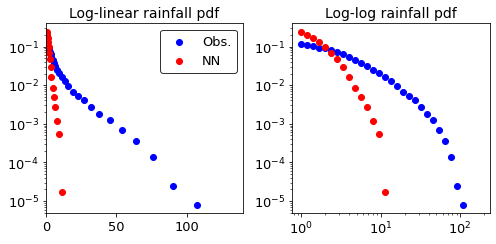

In [265]:
pcp_bins=2**(np.arange(0,8.,0.25))

pcp_pred_hist=np.histogram(prc_predicted,bins=pcp_bins)
pcp_test_hist=np.histogram(prc_test,bins=pcp_bins)


fig,axx=plt.subplots(1,2,figsize=(7,3.5))

ax=axx[0]
ax.scatter(pcp_bins[:-1],pcp_test_hist[0]/(pcp_test_hist[0].sum()),c='blue',label='Obs.')
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red',label='NN')

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(left=0,right=1.4e2)
# ax.set_ylim(bottom=1e-10)
ax.tick_params(which='both',labelsize=13)
ax.legend(fontsize=13).get_frame().set_edgecolor('black')
ax.set_title('Log-linear rainfall pdf',fontsize=14)

ax=axx[1]
ax.scatter(pcp_bins[:-1],pcp_test_hist[0]/(pcp_test_hist[0].sum()),c='blue')
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red')

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(left=0,right=1e2)
# ax.set_ylim(bottom=1e-10)
ax.tick_params(which='both',labelsize=13)
ax.set_title('Log-log rainfall pdf',fontsize=14)

plt.tight_layout()
SAVE=True
if SAVE:
    plt.savefig('/home/fiaz/ML/plots/precip_NNS_pdfs_BL.pdf',
               format='pdf',bbox_inches='tight',dpi=125)

Even three variables are inadequate to get the precip tails correct. The next step is to use the full vertical structure of T and q. Although, one has to be careful since the upper troposphere thermodynamic signature is impacted by convection.